# Neural Machine Translation application using encoder/decoder model and attention mechanism



In [1]:
import tensorflow
from tensorflow.keras.layers import LSTM, Input, TimeDistributed, Dense, Embedding, Dropout, Concatenate, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import numpy as np
import string
import json
import matplotlib.pyplot as plt



# Dataset preprocesing


Load ita/eng row data from .txt file.

In [2]:
path_to_data = "/content/drive/MyDrive/NMT/ita_eng.txt"
translation_file = open(path_to_data, "r", encoding='utf-8')
raw_data = translation_file.read()
translation_file.close()

**Data Parsing :** create a pair list where each element contains two strings; the sentence in Italian and the corresponding sentence / target translated into English.

In [3]:
raw_data = raw_data.split('\n')
pairs = [sentence.split('\t') for sentence in raw_data]
pairs = pairs[:300000]

print("Input/Output example")
print("Italian sentence : %s" % pairs[1000][1])
print("English sentence : %s" % pairs[1000][0])
print()
print("Italian sentence : %s" % pairs[2000][1])
print("English sentence : %s" % pairs[2000][0])
print()
print("Italian sentence : %s" % pairs[3000][1])
print("English sentence : %s" % pairs[3000][0])
print()

Input/Output example
Italian sentence : Amo veramente allenarmi.
English sentence : I really love working out.

Italian sentence : È quasi mezzogiorno ed è ancora a letto.
English sentence : It's nearly noon and he's still in bed.

Italian sentence : Tom è uscito di prigione dopo trent'anni.
English sentence : Tom got out of prison after thirty years.



Lowercase and remove punctuation in sentences

In [4]:
# Lowercase and remove punctuation in sentences
def clean_sentence(sentence):
    # Add a space ' ' befor the ? word
    sentence = sentence.replace('?', ' ?')
    # Lower case the sentence
    lower_case_sent = sentence.lower()
    # Strip punctuation
    string_punctuation = string.punctuation  # !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
    string_punctuation = string_punctuation.replace('?','')
    # Clean the sentence
    clean_sentence = lower_case_sent.translate(str.maketrans('', '', string_punctuation))
    return clean_sentence

Split italian and english sentences in two list and remove punctuation from it.


In [5]:
italian_sentences = [clean_sentence(pair[1]) for pair in pairs]
english_sent      = [clean_sentence(pair[0]) for pair in pairs]

In [6]:
X_train_decoder   = []
Y_train_decoder   = []
english_sentences = []

# Add <start> token at start of every input decoder sentence and
# add <end> token at end of every target decoder sentence.
for sentence in english_sent:
    X_train_decoder.append("<start> " + sentence)
    Y_train_decoder.append(sentence + " <end>")
    english_sentences.append("<start> " + sentence + " <end>")

Tokenize dataset

In [7]:
def tokenize(sentences):
    # Create tokenizer
    text_tokenizer = Tokenizer(filters='')
    # Fit texts
    text_tokenizer.fit_on_texts(sentences)
    return text_tokenizer.texts_to_sequences(sentences), text_tokenizer

In [8]:
# Tokenize encoder input
ita_text_tokenized, ita_text_tokenizer = tokenize(italian_sentences)
# Tokenize decoder input
_, eng_text_tokenizer = tokenize(english_sentences)
eng_in_text_tokenized = eng_text_tokenizer.texts_to_sequences(X_train_decoder)
eng_out_text_tokenized = eng_text_tokenizer.texts_to_sequences(Y_train_decoder)


In [9]:
# Let's add 0 padding to the sentences, to make sure they are all the same length.
# That is, we must be sure that all Italian sentences have the same length as the
# longest Italian sentence and that all English sentences have the same length
# as the longest English sentence
X_train_encoder = pad_sequences(ita_text_tokenized, padding="post")
X_train_decoder = pad_sequences(eng_in_text_tokenized, padding="post")
Y_train_decoder = pad_sequences(eng_out_text_tokenized, padding="post")

# Let's check the length of the vocabulary
# Let's add one unit to size for 0 padding
italian_vocab_size = len(ita_text_tokenizer.word_index) + 1
english_vocab_size = len(eng_text_tokenizer.word_index) + 1

# get the lenght of max italian/english sentence
max_italian_len = X_train_encoder[0].shape[0]
max_english_len = X_train_decoder[0].shape[0]

In [10]:
print("Italian vocabulary has %d words" % italian_vocab_size)
print("English vocabulary has %d words" % english_vocab_size)
print("\n")
print("The max length of an Italian sentence is %d words" % max_italian_len)
print("The max length of an English sentence is %d words" % max_english_len)
print("\n")
print(italian_sentences[1000] + "\n-> " + str(X_train_encoder[1000])+"\n")
print(english_sent[1000]+ "\n-> Input  -> "+ str(X_train_decoder[1000])+"\n-> Target -> "+str(Y_train_decoder[1000])) 

Italian vocabulary has 26179 words
English vocabulary has 12849 words


The max length of an Italian sentence is 12 words
The max length of an English sentence is 13 words


amo veramente allenarmi
-> [ 244  149 9068    0    0    0    0    0    0    0    0    0]

i really love working out
-> Input  -> [  1   5  76 125 284 104   0   0   0   0   0   0   0]
-> Target -> [  5  76 125 284 104   2   0   0   0   0   0   0   0]


Split dataset in training/validation/testing set

In [11]:
X_train_encoder_ = X_train_encoder[:200000]
X_train_decoder_ = X_train_decoder[:200000]
Y_train_decoder_ = Y_train_decoder[:200000]

X_valid_encoder = X_train_encoder[200001:250000]
X_valid_decoder = X_train_decoder[200001:250000]
Y_valid_decoder = Y_train_decoder[200001:250000]

X_test_encoder = X_train_encoder[250001:]
X_test_decoder = X_train_decoder[250001:]
Y_test_decoder = Y_train_decoder[250001:]

X_train_encoder = X_train_encoder_
X_train_decoder = X_train_decoder_
Y_train_decoder = Y_train_decoder_

print("Train set has %d sentences" %len(X_train_encoder))
print("Validation set has %d sentences" %len(X_valid_encoder))
print("Test set has %d sentences" %len(X_test_encoder))


Train set has 200000 sentences
Validation set has 49999 sentences
Test set has 49999 sentences


# Define and train model without attention mechanism

In [12]:
# Encoder
encoder_input = Input(shape=[None], dtype=tensorflow.int32)
encoder_embedding = Embedding(input_dim=italian_vocab_size+1,
                              output_dim=256,
                              mask_zero=True)(encoder_input)

_, enc_state_h, enc_state_c = LSTM(256, #dropout=0.3,
                                        #recurrent_dropout=0.3,
                                      return_state=True,
                                      return_sequences=False)(encoder_embedding)
# Save the state of the last step of the encoder which will be the initial state of the decoder.
encoder_state = [enc_state_h, enc_state_c]  

# Decoder
decoder_input = Input(shape=[None], dtype=tensorflow.int32)
decoder_embedding = Embedding(input_dim=english_vocab_size+1,
                              output_dim=256,
                              mask_zero=True)(decoder_input)
decoder_lstm_output, dec_state_h, dec_state_c = LSTM(256, #dropout=0.3,
                                                          #recurrent_dropout=0.3,
                                                    return_sequences=True,
                                                    return_state=True)(decoder_embedding, initial_state=encoder_state)
        
decoder_lstm_output_dropout = Dropout(0.5)(decoder_lstm_output)
decoder_output = TimeDistributed(Dense(english_vocab_size, activation="softmax"))(decoder_lstm_output_dropout)

# Define model
model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    6702080     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    3289600     input_2[0][0]                    
______________________________________________________________________________________________

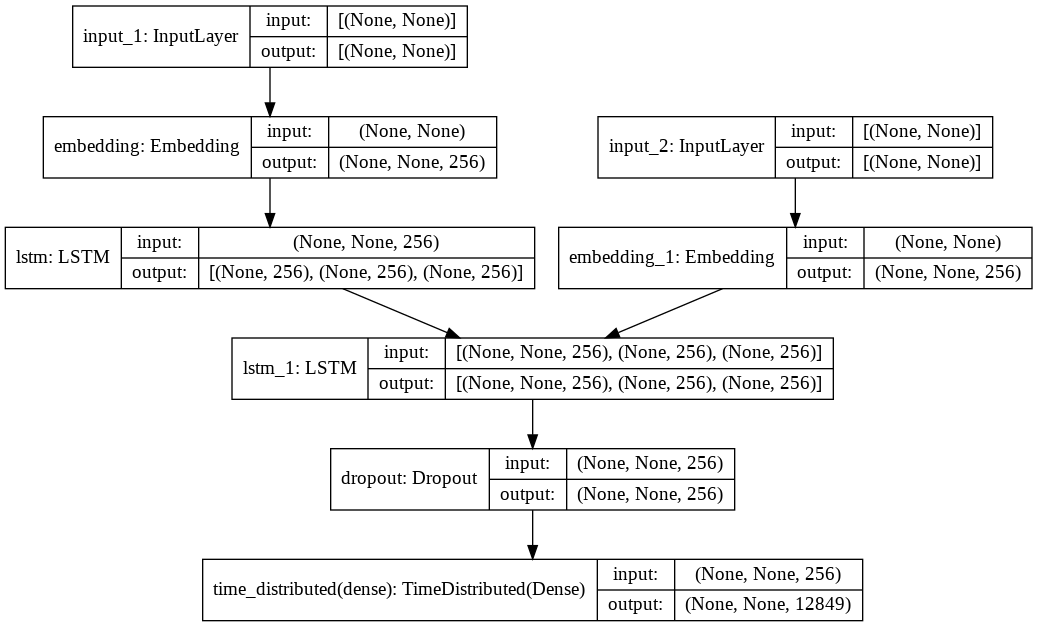

In [14]:
tensorflow.keras.utils.plot_model(model, to_file='model_without_attention.png', show_shapes=True)

In [ ]:
model_name = "without_attention.h5"
mcp_save = ModelCheckpoint(filepath=model_name,
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min',
                           verbose=1)

history = model.fit([X_train_encoder, X_train_decoder], Y_train_decoder,
                    epochs=25,
                    validation_data=([X_valid_encoder, X_valid_decoder], Y_valid_decoder),
                    verbose=2,
                    batch_size=128,
                    callbacks=mcp_save)

model.save("final_epoch_"+model_name)

history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history.json', 'w'))

The best result was :

`[epoch 21] : loss: 0.1336 - accuracy: 0.9249 - val_loss: 0.2882 - val_accuracy: 0.8887`





In [15]:
def plot_training_accuracy(history, savePlot=False, title = "fig"):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
    if savePlot:
        plt.savefig(title+'_loss.png')
    plt.show()

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if savePlot:
        plt.savefig(title+'_acc.png')
    plt.show()

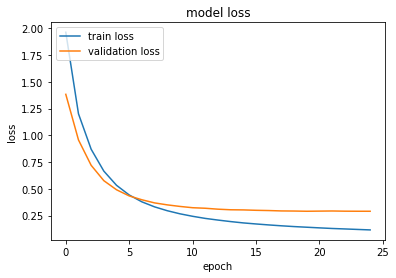

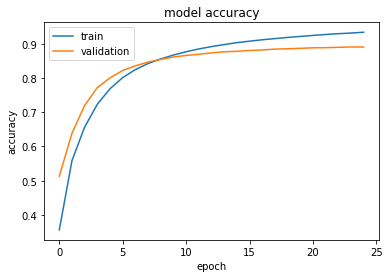

In [16]:
path = "/content/drive/MyDrive/NMT/history_without_att.json"
history_dict_without_att = json.load(open(path, 'r'))
plot_training_accuracy(history = history_dict_without_att, savePlot=False, title = "prova")

# Inference phase on encoder/decoder model with teacher forcing without attention mechanism

Build (and restore loaded) model that NOT use attention mechanism for inference time

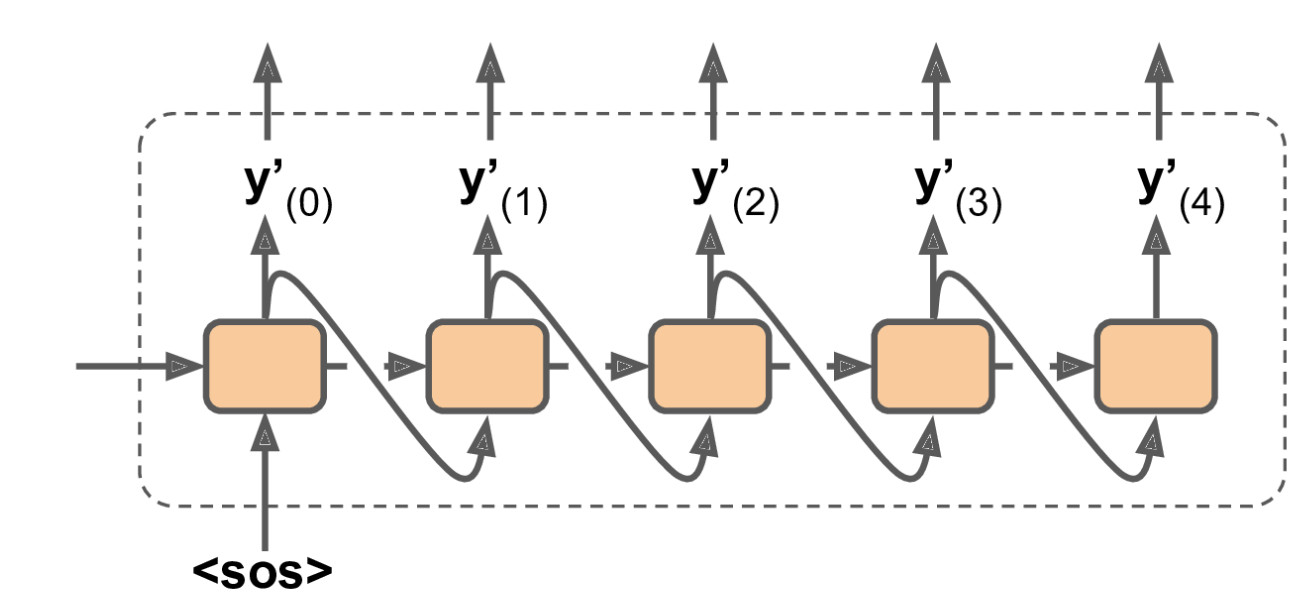

In [17]:
model_name = "/content/drive/MyDrive/NMT/model_without_attention.h5"
model = load_model(model_name)
for layer in model.layers:
    print(layer.name)

input_1
input_2
embedding
embedding_1
lstm
lstm_1
dropout
time_distributed


In [18]:
# Encoder
encoder_input = model.input[0]
_, state_h, state_c = model.layers[4].output
encoder_states = [state_h, state_c]
encoder_model = Model(encoder_input, # input encoder model
                      encoder_states)# output encoder model

# Decoder
decoder_input = model.input[1]
embeded_decoder = model.layers[3]
embeded_decoder = embeded_decoder(decoder_input)
decoder_state_h = Input(shape=(256), name="input_3")
decoder_state_c = Input(shape=(256), name="input_4")
decoder_state_inputs = [decoder_state_h,decoder_state_c]
decoder_lstm = model.layers[5]
decoder_outputs, state_h, state_c = decoder_lstm(embeded_decoder, initial_state=decoder_state_inputs)
decoder_states = [state_h,state_c]

# decoder outputs
dropout_out = model.layers[6]
dropout_out = dropout_out(decoder_outputs)
decoder_dense = model.layers[7]
decoder_outputs = decoder_dense(dropout_out)

decoder_model = Model([decoder_input]+decoder_state_inputs, # input decoder model
                          [decoder_outputs]+decoder_states) # output decoder model

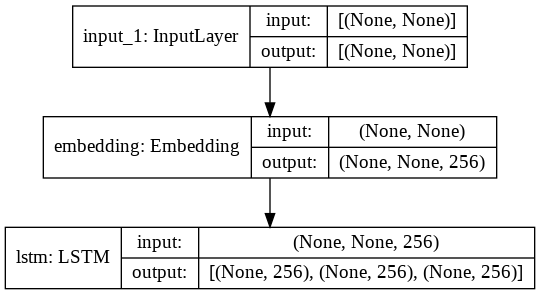

In [19]:
tensorflow.keras.utils.plot_model(encoder_model, to_file='encoder_inference_no_attention.png', show_shapes=True)

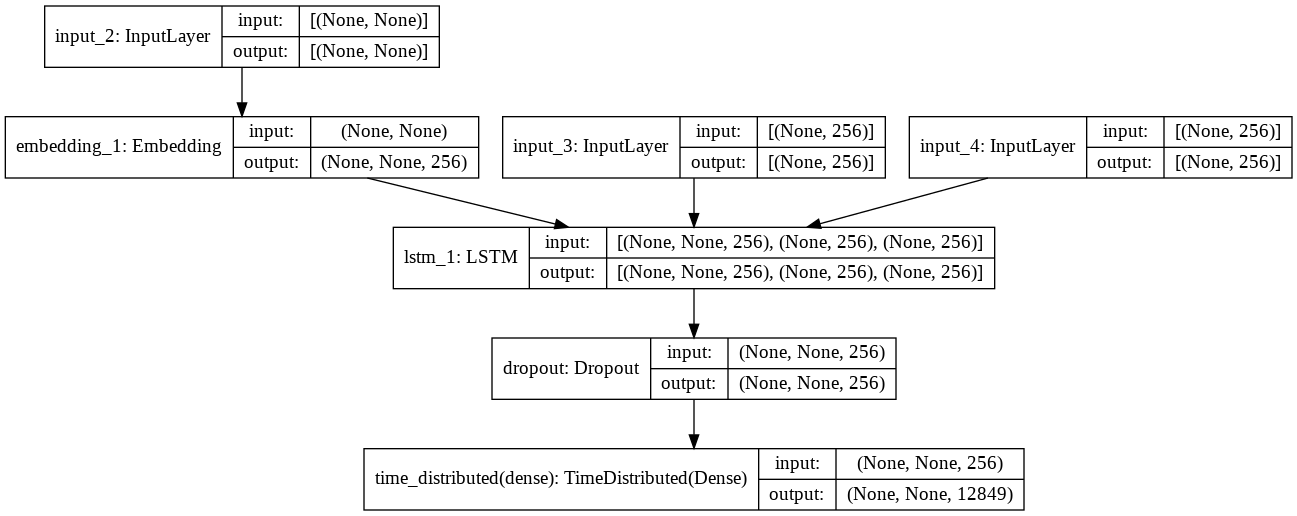

In [20]:
tensorflow.keras.utils.plot_model(decoder_model, to_file='decoder_inference_no_attention.png', show_shapes=True)

Pre procesing on input sentence

In [21]:
def pre_processing_sentece(sentence):
    sentence = clean_sentence(sentence)
    # Tokenize words
    sentence_tokenized = ita_text_tokenizer.texts_to_sequences([sentence])
    sentence_tokenized = pad_sequences(sentence_tokenized, max_italian_len, padding="post")
    return sentence_tokenized

Inference phase on encoder/decoder using teacher forcing but without attention mechanism

In [22]:
def inference_without_attention(sentence):
    # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
    state_h, state_c = encoder_model.predict(sentence)

    # Define target word
    target_word = np.zeros((1,1))
    # <start>:1 , <end>:2
    target_word[0,0] = 1

    stop_condition=False
    # Define output sentence string
    sent=''
    step_size=0

    index_to_words = {idx: word for word, idx in eng_text_tokenizer.word_index.items()}
    while not stop_condition:

        # We are giving a target_word which represents <start> and encoder_states to the decoder_model
        # for the first step and the output at the previous step for the next steps after the first
        output, state_h, state_c = decoder_model.predict([target_word, state_h, state_c])

        # As the target word length is 1. We will only have one time step
        #encoder_state_value = [state_h, state_c]
        # Find the word which the decoder predicted with max_probability
        output = np.argmax(output,-1)
        # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
        sent = sent+' '+str(index_to_words.get(int(output)))
        step_size+=1
        # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop the model
        if step_size>max_english_len or output==2:
          stop_condition = True
        # Define next decoder input
        target_word=output.reshape(1,1)

    return sent

Inference on new sentence

In [23]:
sentences = ["come stai?",
             "quanti anni hai?",
             "come ti chiami?",
             "è una bellissima giornata",
             "sei una ragazza pericolosa",
             "ho studiato duramente per superare l'esame",
             "mia madre dice sempre che sono bello"
             ]

for sentence in sentences:
    sentence_tokenized = pre_processing_sentece(sentence)
    translated_sentence = inference_without_attention(sentence_tokenized)
    print("Input  sentence :  %s" % sentence)
    print("Output sentence : %s" % translated_sentence)
    print()

Input  sentence :  come stai?
Output sentence :  how are you ? <end>

Input  sentence :  quanti anni hai?
Output sentence :  how old are you ? <end>

Input  sentence :  come ti chiami?
Output sentence :  whats your name ? <end>

Input  sentence :  è una bellissima giornata
Output sentence :  its a beautiful day <end>

Input  sentence :  sei una ragazza pericolosa
Output sentence :  youre a dangerous girl <end>

Input  sentence :  ho studiato duramente per superare l'esame
Output sentence :  i studied hard in order to pass the examination <end>

Input  sentence :  mia madre dice sempre che sono bello
Output sentence :  my mother always says hes handsome <end>



Inference from testing set

In [24]:
sentences = []
sentences.append(["conosco una ragazza che parla molto bene il francese", "i know a girl who speaks french very well"])
sentences.append(["che cosa fareste se questo fosse il vostro ultimo giorno?", "what would you do if this was your last day ?"])
sentences.append(["le previsioni del tempo dicono che farà bello domani","the weather forecast says it will be fine tomorrow" ])
sentences.append(["dove posso comprare una chitarra da queste parti ?", "where can i buy a guitar around here?"])

for sentence in sentences:
    sentence_tokenized = pre_processing_sentece(sentence[0])
    translated_sentence = inference_without_attention(sentence_tokenized)
    print("Input  sentence :  %s" % sentence[0])
    print("Target sentence :  %s" % sentence[1])
    print("Output sentence : %s" % translated_sentence)
    print()


Input  sentence :  conosco una ragazza che parla molto bene il francese
Target sentence :  i know a girl who speaks french very well
Output sentence :  i know a girl who speaks french very well <end>

Input  sentence :  che cosa fareste se questo fosse il vostro ultimo giorno?
Target sentence :  what would you do if this was your last day ?
Output sentence :  what would you do if this was your last day ? <end>

Input  sentence :  le previsioni del tempo dicono che farà bello domani
Target sentence :  the weather forecast says it will be fine tomorrow
Output sentence :  the weather say you plan now think well <end>

Input  sentence :  dove posso comprare una chitarra da queste parti ?
Target sentence :  where can i buy a guitar around here?
Output sentence :  where can i buy a nearby area ? <end>



# Define and train model with attention mechanism

In [25]:
# Encoder
encoder_input = Input(shape=[None], dtype=tensorflow.int32)
encoder_embedding = Embedding(input_dim=italian_vocab_size+1,
                              output_dim=256,
                              mask_zero=True)(encoder_input)

# If we train the model with attention mechanism, we must return the LSTM output for each step
encoder_lstm_output, enc_state_h, enc_state_c = LSTM(256, #dropout=0.3,
                                                     #recurrent_dropout=0.3,
                                                     return_state=True,
                                                     return_sequences=True)(encoder_embedding)
encoder_state = [enc_state_h, enc_state_c]  # save the state of the last step of the encoder which will be the initial state of the decoder.

# Decoder
decoder_input = Input(shape=[None], dtype=tensorflow.int32)
decoder_embedding = Embedding(input_dim=english_vocab_size+1,
                              output_dim=256,
                              mask_zero=True)(decoder_input)
decoder_lstm_output, dec_state_h, dec_state_c = LSTM(256, #dropout=0.3,
                                                     #recurrent_dropout=0.3,
                                                     return_sequences=True,
                                                     return_state=True)(decoder_embedding, initial_state=encoder_state)
# If we train the model with attention mechanism,
# we use the dot method to create the alignment vector definid in Luong Attention
##############
dot_prod = Dot(axes=(2, 2))([decoder_lstm_output, encoder_lstm_output])
attention = Activation('softmax', name='attention')
attention_vec = attention(dot_prod)
context = Dot(axes=(2, 1))([attention_vec, encoder_lstm_output])
conc_out = Concatenate()([context, decoder_lstm_output])
##############
decoder_lstm_output_dropout = Dropout(0.4)(conc_out)

decoder_output = TimeDistributed(Dense(english_vocab_size, activation="softmax"))(decoder_lstm_output_dropout)

model = Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])


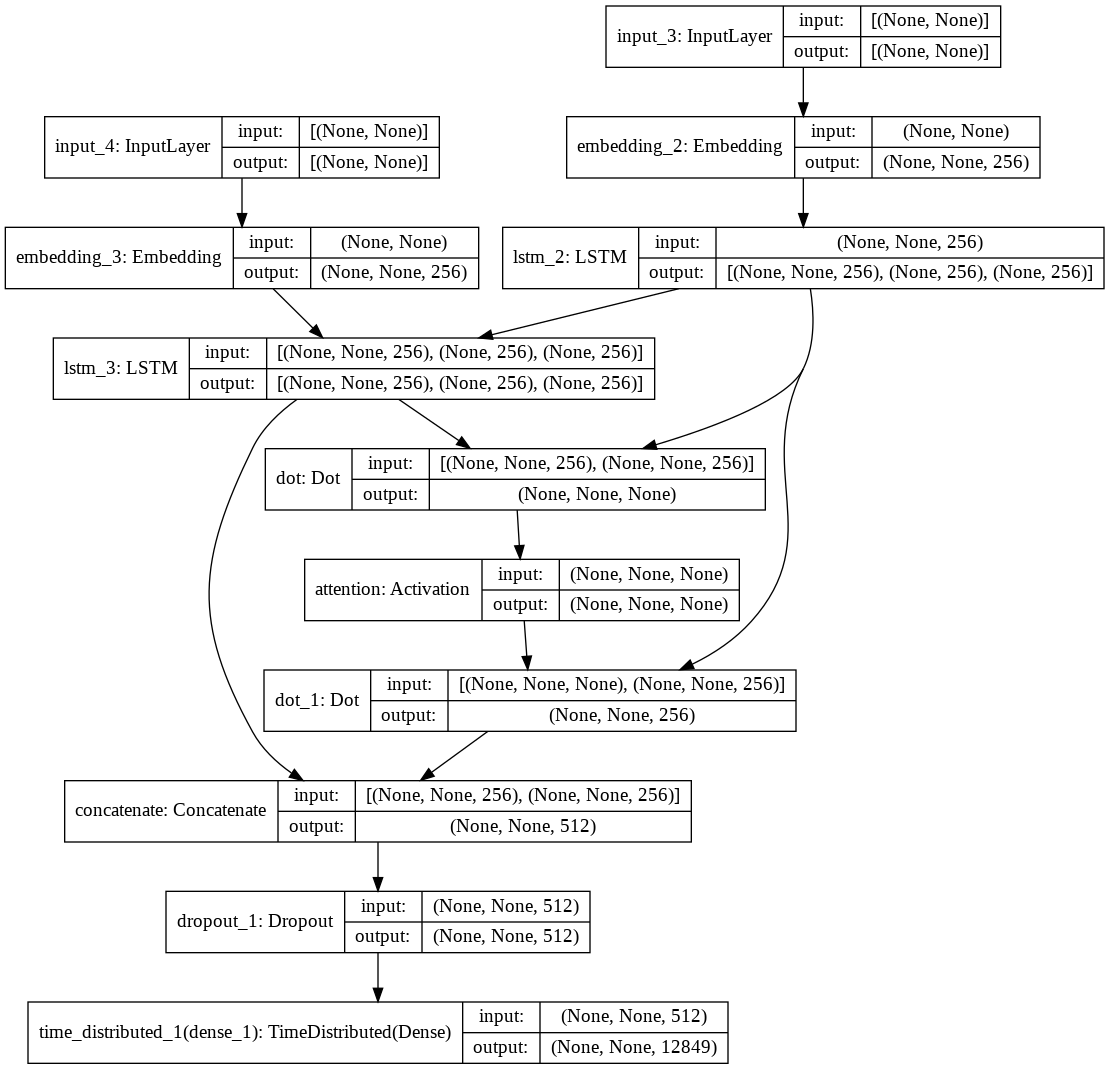

In [26]:
tensorflow.keras.utils.plot_model(model, to_file='model_with_attention.png', show_shapes=True)

In [ ]:
model_name = "wit_attention.h5"
mcp_save = ModelCheckpoint(filepath=model_name,
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min',
                           verbose=1)

history = model.fit([X_train_encoder, X_train_decoder], Y_train_decoder,
                    epochs=25,
                    validation_data=([X_valid_encoder, X_valid_decoder], Y_valid_decoder),
                    verbose=2,
                    batch_size=128,
                    callbacks=mcp_save)

model.save("final_epoch_"+model_name)

history_dict = history.history
# Save it under the form of a json file
json.dump(history_dict, open('history.json', 'w'))

In [27]:
def plot_training_accuracy_together(history_no_att, history_si_att, savePlot=False, title = "fig"):
    plt.plot(history_no_att['loss'])
    plt.plot(history_si_att['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['without attention loss', 'with attention loss'], loc='upper right')
    if savePlot:
        plt.savefig(title+'_loss.png')
    plt.show()

    plt.plot(history_no_att['val_accuracy'])
    plt.plot(history_si_att['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['without attention val acc', 'with attention val acc'], loc='lower right')
    if savePlot:
        plt.savefig(title+'_acc.png')
    plt.show()

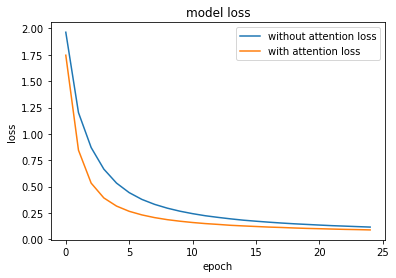

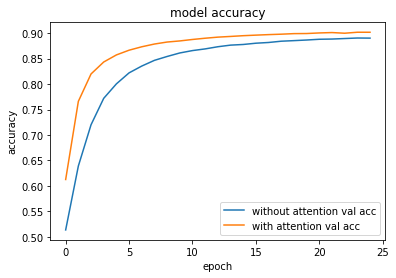

In [28]:
history_dict_with_att = json.load(open('/content/drive/MyDrive/NMT/history_with_att.json', 'r'))
history_dict_without_att = json.load(open('/content/drive/MyDrive/NMT/history_without_att.json', 'r'))

plot_training_accuracy_together(history_dict_without_att, history_dict_with_att, savePlot=True, title = "with_att")

The best result was :

`Without attention : [epoch 21] : loss: 0.1336 - accuracy: 0.9249 - val_loss: 0.2882 - val_accuracy: 0.8887`

`With attention :    [epoch 16] : loss: 0.1213 - accuracy: 0.9323 - val_loss: 0.2697 - val_accuracy: 0.8962`


# Inference phase on encoder/decoder model with teacher forcing with attention mechanism


Build (and restore loaded) model that use attention mechanism for inference time

In [ ]:
model_name = "/content/drive/MyDrive/NMT/model_with_attention.h5"
model = load_model(model_name)
for layer in model.layers:
    print(layer.name)

input_1
input_2
embedding
embedding_1
lstm
lstm_1
dot
attention
dot_1
concatenate
dropout
time_distributed


In [ ]:
# encoder
encoder_input = model.input[0]
encoder_lstm_output, encoder_state_h, encoder_state_c = model.layers[4].output
encoder_lstm_states = [encoder_state_h, encoder_state_c]
encoder_model = Model(encoder_input, # input encoder model
                      [encoder_lstm_output, encoder_state_h, encoder_state_c]) # output encoder model

# decoder
decoder_input = model.input[1]
embeded_decoder = model.layers[3]
embeded_decoder = embeded_decoder(decoder_input)
decoder_state_h = Input(shape=(256), name="input_3")
decoder_state_c = Input(shape=(256), name="input_4")
decoder_state_inputs = [decoder_state_h, decoder_state_c]
decoder_lstm = model.layers[5]
decoder_output_lstm, state_h, state_c = decoder_lstm(embeded_decoder, initial_state=decoder_state_inputs)
decoder_states = [state_h,state_c]

# Attention mechanism in decoder
encoder_out_as_input = Input(shape=(None, 256), name="input_5")
dot_layer = model.layers[6]
activation_dot_layer = model.layers[7]
attention = dot_layer([decoder_output_lstm, encoder_out_as_input])
attention = activation_dot_layer(attention)
dot_layer2 = model.layers[8]
context  = dot_layer2([attention, encoder_out_as_input])
conc_out = model.layers[9]
conc_out = conc_out([context, decoder_output_lstm])

# Decoder output
dropout_out = model.layers[10]
dropout_out = dropout_out(conc_out)
decoder_dense = model.layers[11]
decoder_outputs = decoder_dense(dropout_out)

decoder_model = Model([decoder_input, encoder_out_as_input, decoder_state_inputs], # input decoder model
                      [decoder_outputs]+decoder_states) # output decoder model

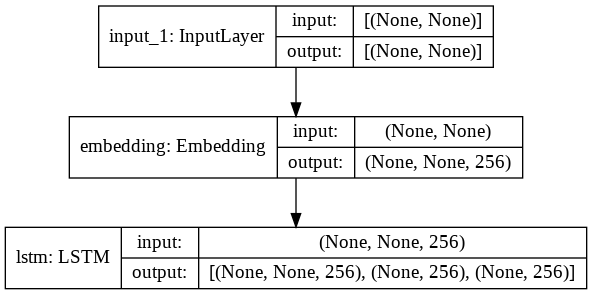

In [ ]:
tensorflow.keras.utils.plot_model(encoder_model, to_file='encoder_inference_with_attention.png', show_shapes=True)

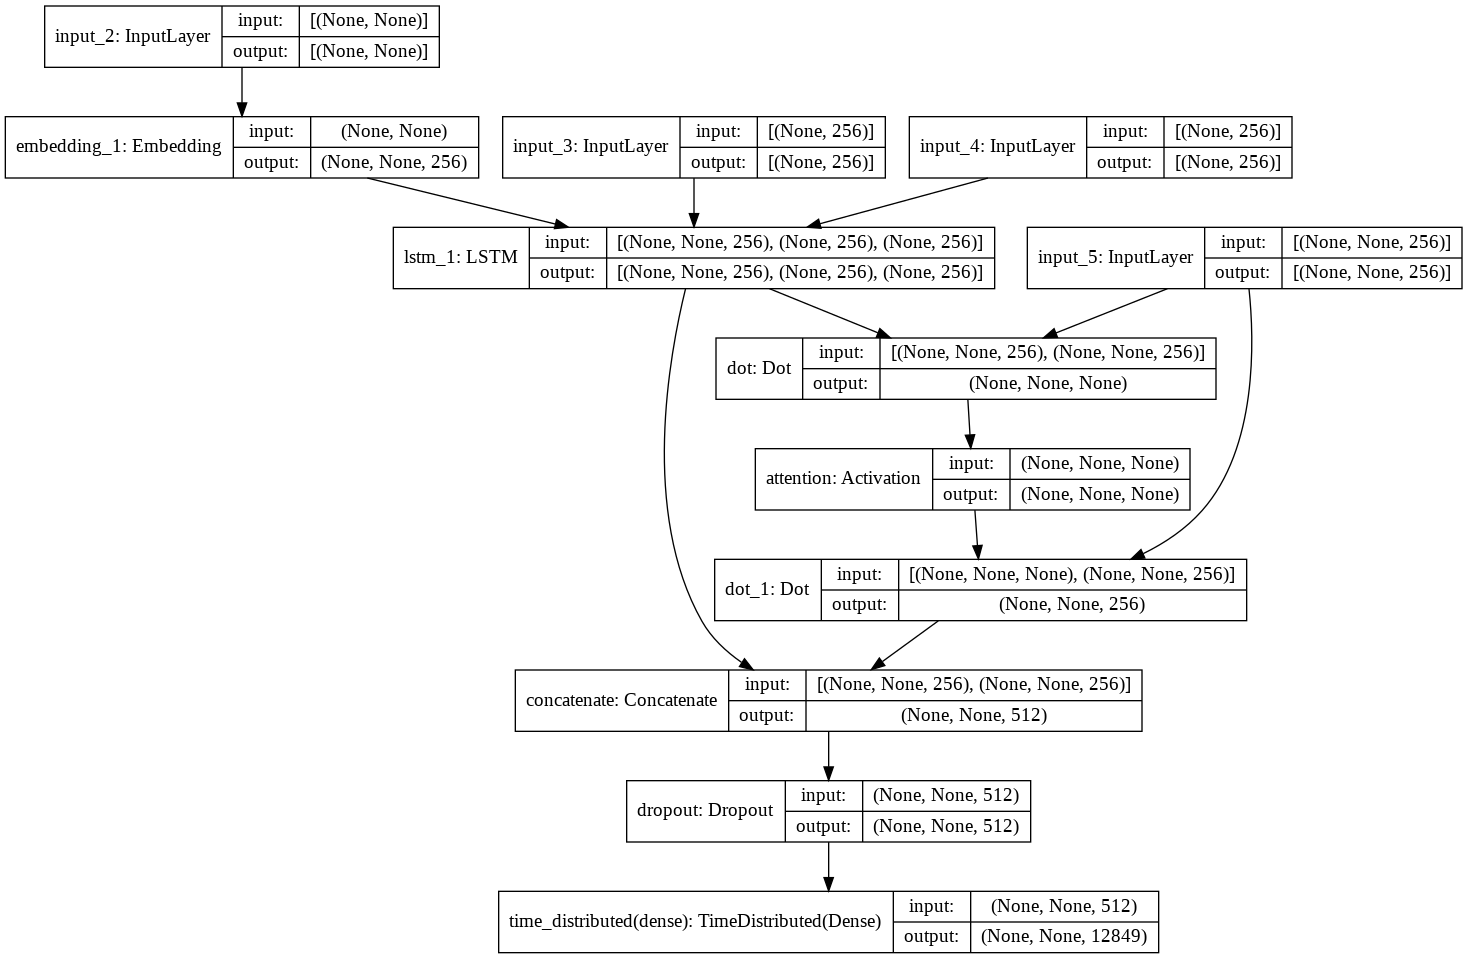

In [ ]:
tensorflow.keras.utils.plot_model(decoder_model, to_file='decoder_inference_with_attention.png', show_shapes=True)

Pre procesing on input sentence

In [ ]:
def pre_processing_sentece(sentence):
    sentence = clean_sentence(sentence)
    # Tokenize words
    sentence_tokenized = ita_text_tokenizer.texts_to_sequences([sentence])
    sentence_tokenized = pad_sequences(sentence_tokenized, max_italian_len, padding="post")
    return sentence_tokenized

Inference phase on encoder/decoder using teacher forcing but with attention mechanism

In [ ]:
def inference_with_attention(sentence):
    encoder_output, state_h, state_c = encoder_model.predict(sentence)

    # Define target word
    target_word = np.zeros((1,1))
    # <start>:1 , <end>:2
    target_word[0,0] = 1

    stop_condition=False
    # Define output sentence string
    sent=''
    step_size=0

    index_to_words = {idx: word for word, idx in eng_text_tokenizer.word_index.items()}
    while not stop_condition:

        # We are giving a target_word which represents <start> and encoder_states to the decoder_model
        # for the first step and the output at the previous step for the next steps after the first
        # If attention mechanism is active, we give as input the encoder output also
        output, state_h, state_c = decoder_model.predict([target_word, encoder_output, [state_h, state_c]])
 
        # As the target word length is 1. We will only have one time step
        #encoder_state_value = [state_h, state_c]
        # Find the word which the decoder predicted with max_probability
        output = np.argmax(output,-1)
        # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
        sent = sent+' '+str(index_to_words.get(int(output)))
        step_size+=1
        # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop the model
        if step_size>max_english_len or output==2:
           stop_condition = True
        # Define next decoder input
        target_word=output.reshape(1,1)

    return sent

Inference on new sentence



In [ ]:
sentences = []
sentences.append(["mia madre dice sempre che sono bello", "my mother always says im handsome", "my mother always says hes handsome"])
sentences.append(["le previsioni del tempo dicono che farà bello domani", "the weather forecast says it will be fine tomorrow", "the weather say you plan now think well"])
sentences.append(["dove posso comprare una chitarra da queste parti ?","where can i buy a guitar around here ?", "where can i buy a nearby area ?" ])

for sentence in sentences:
    sentence_tokenized = pre_processing_sentece(sentence[0])
    translated_sentence = inference_with_attention(sentence_tokenized)
    print("Input sentence             : %s" % sentence[0])
    print("Target sentence            : %s" % sentence[1])
    print("Without attention sentence : %s" % sentence[2])
    print("With attention sentence    :%s" % translated_sentence)
    print()

Input sentence             : mia madre dice sempre che sono bello
Target sentence            : my mother always says im handsome
Without attention sentence : my mother always says hes handsome
With attention sentence    : my mother always says im handsome <end>

Input sentence             : le previsioni del tempo dicono che farà bello domani
Target sentence            : the weather forecast says it will be fine tomorrow
Without attention sentence : the weather say you plan now think well
With attention sentence    : the weather report says its going to good tomorrow <end>

Input sentence             : dove posso comprare una chitarra da queste parti ?
Target sentence            : where can i buy a guitar around here ?
Without attention sentence : where can i buy a nearby area ?
With attention sentence    : where can i buy a guitar around here ? <end>

